In [19]:
import pandas as pd
import pymysql.cursors
import xgboost as xgb
import catboost
import numpy as np

In [20]:
df = pd.read_csv('Ya_browser.csv')
df.columns

Index(['Время', 'Amigo, Визиты', 'Amigo, Доля', 'UC Browser, Визиты',
       'UC Browser, Доля', 'Internet Explorer, Визиты',
       'Internet Explorer, Доля', 'Android Browser, Визиты',
       'Android Browser, Доля', 'Firefox, Визиты', 'Firefox, Доля',
       'Opera, Визиты', 'Opera, Доля', 'Safari, Визиты', 'Safari, Доля',
       'Яндекс.Браузер, Визиты', 'Яндекс.Браузер, Доля',
       'Google Chrome, Визиты', 'Google Chrome, Доля', 'Edge, Визиты',
       'Edge, Доля', 'Samsung Internet, Визиты', 'Samsung Internet, Доля',
       'MIUI browser, Визиты', 'MIUI browser, Доля', 'Остальные, Визиты',
       'Остальные, Доля'],
      dtype='object')

In [21]:
df = df[['Время','Яндекс.Браузер, Визиты']]
df.head()

,Время,"Яндекс.Браузер, Визиты"
0,2015-01-05 - 2015-01-11,327999377
1,2015-01-12 - 2015-01-18,351278446
2,2015-01-19 - 2015-01-25,367119713
3,2015-01-26 - 2015-02-01,368903905
4,2015-02-02 - 2015-02-08,368813514


In [22]:
df['Время'] = df['Время'].map(lambda x: x[:10])

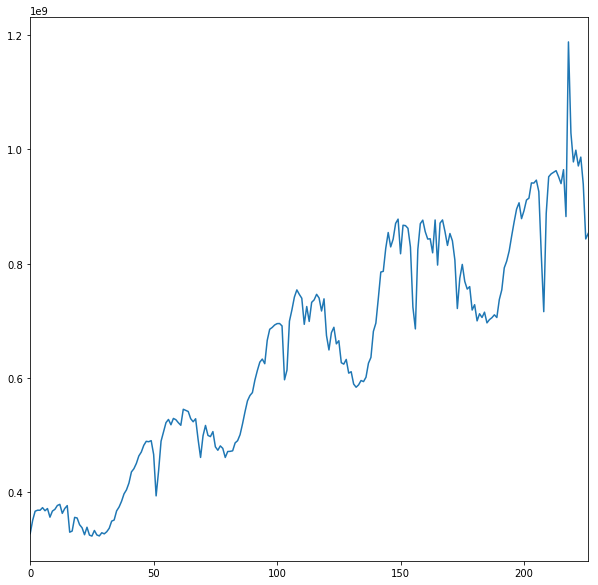

In [13]:
df[df.columns[1]].plot(figsize=(10,10))

In [26]:
df['report_date'] = df['Время'].astype('datetime64')
df['day'] = df['report_date'].map(lambda x: x.day)
df['month'] = df['report_date'].map(lambda x: x.month)
df['year'] = df['report_date'].map(lambda x: x.year)

In [27]:
df.dtypes

Время                             object
Яндекс.Браузер, Визиты             int64
report_date               datetime64[ns]
month                              int64
year                               int64
day                                int64
dtype: object

In [97]:
def prepare_data(data, test_size = 0.1):
    test_index = int(len(data)*(1-test_size))
    for i in range(1,52):
        data['count_shift{0}'.format(i)] = data['Яндекс.Браузер, Визиты'].shift(i)
    data = data.drop(['report_date', 'Время'], axis=1)
    x_train = data.loc[:test_index].drop(['Яндекс.Браузер, Визиты'], axis=1)
    y_train = data.loc[:test_index]['Яндекс.Браузер, Визиты']
    x_test = data.loc[test_index:].drop(['Яндекс.Браузер, Визиты'], axis=1)
    y_test = data.loc[test_index:]['Яндекс.Браузер, Визиты']

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = prepare_data(df)

In [45]:
x_train.head()

,month,year,day,count_shift1,count_shift2,count_shift3,count_shift4,count_shift5,count_shift6,count_shift7,...,count_shift42,count_shift43,count_shift44,count_shift45,count_shift46,count_shift47,count_shift48,count_shift49,count_shift50,count_shift51
0,1,2015,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015,12,327999377.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2015,19,351278446.0,327999377.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2015,26,367119713.0,351278446.0,327999377.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2015,2,368903905.0,367119713.0,351278446.0,327999377.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
x_test

,month,year,day,count_shift1,count_shift2,count_shift3,count_shift4,count_shift5,count_shift6,count_shift7,...,count_shift42,count_shift43,count_shift44,count_shift45,count_shift46,count_shift47,count_shift48,count_shift49,count_shift50,count_shift51
204,12,2018,3,9.410745e+08,9.144939e+08,9.111295e+08,8.925358e+08,8.786398e+08,9.063613e+08,8.954499e+08,...,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0,824838033.0,685859291.0,723961748.0,829009410.0,861757702.0
205,12,2018,10,9.408466e+08,9.410745e+08,9.144939e+08,9.111295e+08,8.925358e+08,8.786398e+08,9.063613e+08,...,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0,824838033.0,685859291.0,723961748.0,829009410.0
206,12,2018,17,9.459505e+08,9.408466e+08,9.410745e+08,9.144939e+08,9.111295e+08,8.925358e+08,8.786398e+08,...,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0,824838033.0,685859291.0,723961748.0
207,12,2018,24,9.259519e+08,9.459505e+08,9.408466e+08,9.410745e+08,9.144939e+08,9.111295e+08,8.925358e+08,...,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0,824838033.0,685859291.0
208,12,2018,31,8.155698e+08,9.259519e+08,9.459505e+08,9.408466e+08,9.410745e+08,9.144939e+08,9.111295e+08,...,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0,824838033.0
209,1,2019,7,7.160115e+08,8.155698e+08,9.259519e+08,9.459505e+08,9.408466e+08,9.410745e+08,9.144939e+08,...,876378444.0,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0,869827442.0
210,1,2019,14,8.880650e+08,7.160115e+08,8.155698e+08,9.259519e+08,9.459505e+08,9.408466e+08,9.410745e+08,...,855914635.0,876378444.0,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0,876019193.0
211,1,2019,21,9.519169e+08,8.880650e+08,7.160115e+08,8.155698e+08,9.259519e+08,9.459505e+08,9.408466e+08,...,831811795.0,855914635.0,876378444.0,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0,855813969.0
212,1,2019,28,9.569363e+08,9.519169e+08,8.880650e+08,7.160115e+08,8.155698e+08,9.259519e+08,9.459505e+08,...,852630927.0,831811795.0,855914635.0,876378444.0,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0,842962258.0
213,2,2019,4,9.597918e+08,9.569363e+08,9.519169e+08,8.880650e+08,7.160115e+08,8.155698e+08,9.259519e+08,...,839915723.0,852630927.0,831811795.0,855914635.0,876378444.0,870817429.0,797457940.0,876301001.0,818852449.0,843448440.0


In [46]:
model = catboost.CatBoostRegressor(learning_rate=0.3, iterations=1500, depth=3)
cat_features = [0, 1, 2]
model.fit(x_train, y_train, cat_features= cat_features)

0:	learn: 458407279.4300351	total: 27.3ms	remaining: 40.9s
1:	learn: 337903450.1717690	total: 51.1ms	remaining: 38.3s
2:	learn: 247714224.0574829	total: 71.6ms	remaining: 35.7s
3:	learn: 185980731.3087996	total: 94.7ms	remaining: 35.4s
4:	learn: 143125553.1866942	total: 125ms	remaining: 37.5s
5:	learn: 111107629.4928264	total: 148ms	remaining: 36.9s
6:	learn: 88900948.4493681	total: 172ms	remaining: 36.7s
7:	learn: 77464578.6861402	total: 197ms	remaining: 36.7s
8:	learn: 69860490.7172332	total: 231ms	remaining: 38.3s
9:	learn: 65708351.1406529	total: 257ms	remaining: 38.4s
10:	learn: 63431273.1487834	total: 279ms	remaining: 37.8s
11:	learn: 61985961.9906738	total: 302ms	remaining: 37.4s
12:	learn: 59990406.5168127	total: 327ms	remaining: 37.3s
13:	learn: 58275400.3994613	total: 352ms	remaining: 37.4s
14:	learn: 57919918.5850638	total: 377ms	remaining: 37.3s
15:	learn: 55202564.8627239	total: 409ms	remaining: 38s
16:	learn: 52507443.3845396	total: 448ms	remaining: 39s
17:	learn: 5221184

147:	learn: 26341726.1034191	total: 4.01s	remaining: 36.6s
148:	learn: 26139931.1840228	total: 4.03s	remaining: 36.5s
149:	learn: 26087354.4923972	total: 4.05s	remaining: 36.4s
150:	learn: 26079989.8087349	total: 4.07s	remaining: 36.4s
151:	learn: 25982671.7185646	total: 4.09s	remaining: 36.3s
152:	learn: 25979965.9261232	total: 4.13s	remaining: 36.4s
153:	learn: 25960493.3148340	total: 4.15s	remaining: 36.3s
154:	learn: 25875564.2825695	total: 4.18s	remaining: 36.3s
155:	learn: 25857521.0740034	total: 4.21s	remaining: 36.3s
156:	learn: 25835040.7733664	total: 4.23s	remaining: 36.2s
157:	learn: 25830374.6593351	total: 4.25s	remaining: 36.1s
158:	learn: 25794635.3696373	total: 4.28s	remaining: 36.1s
159:	learn: 25673074.8375904	total: 4.3s	remaining: 36s
160:	learn: 25502078.1082336	total: 4.33s	remaining: 36.1s
161:	learn: 25438519.3926246	total: 4.36s	remaining: 36s
162:	learn: 25182441.7475892	total: 4.38s	remaining: 36s
163:	learn: 25069649.0714634	total: 4.41s	remaining: 35.9s
164:

289:	learn: 20570435.4382131	total: 7.64s	remaining: 31.9s
290:	learn: 20422002.3080273	total: 7.66s	remaining: 31.8s
291:	learn: 20230999.8934188	total: 7.68s	remaining: 31.8s
292:	learn: 20226393.1110148	total: 7.71s	remaining: 31.8s
293:	learn: 20221868.4176070	total: 7.73s	remaining: 31.7s
294:	learn: 20198560.1858843	total: 7.75s	remaining: 31.7s
295:	learn: 20189086.4589908	total: 7.78s	remaining: 31.6s
296:	learn: 20188111.1524117	total: 7.82s	remaining: 31.7s
297:	learn: 20169806.5163420	total: 7.84s	remaining: 31.6s
298:	learn: 20163075.5958642	total: 7.87s	remaining: 31.6s
299:	learn: 20159932.4619335	total: 7.89s	remaining: 31.6s
300:	learn: 20145182.8167933	total: 7.92s	remaining: 31.5s
301:	learn: 20145076.1618667	total: 7.94s	remaining: 31.5s
302:	learn: 20134884.2429665	total: 7.97s	remaining: 31.5s
303:	learn: 20122477.6658969	total: 7.99s	remaining: 31.4s
304:	learn: 20119739.7246000	total: 8.02s	remaining: 31.4s
305:	learn: 20115018.8415768	total: 8.05s	remaining: 31.

435:	learn: 17059847.6584512	total: 11.3s	remaining: 27.6s
436:	learn: 17058111.8876039	total: 11.3s	remaining: 27.6s
437:	learn: 17023740.9144849	total: 11.4s	remaining: 27.5s
438:	learn: 17020543.6736936	total: 11.4s	remaining: 27.5s
439:	learn: 17019155.6192639	total: 11.4s	remaining: 27.5s
440:	learn: 17010113.5070303	total: 11.4s	remaining: 27.5s
441:	learn: 16984110.7570792	total: 11.5s	remaining: 27.4s
442:	learn: 16975218.0172831	total: 11.5s	remaining: 27.4s
443:	learn: 16927568.7114246	total: 11.5s	remaining: 27.4s
444:	learn: 16914844.3268645	total: 11.5s	remaining: 27.3s
445:	learn: 16903975.0694573	total: 11.6s	remaining: 27.3s
446:	learn: 16898095.4833527	total: 11.6s	remaining: 27.3s
447:	learn: 16860600.7287801	total: 11.6s	remaining: 27.3s
448:	learn: 16847435.1071383	total: 11.7s	remaining: 27.3s
449:	learn: 16834404.8466358	total: 11.7s	remaining: 27.3s
450:	learn: 16831147.3035710	total: 11.7s	remaining: 27.2s
451:	learn: 16761558.8010163	total: 11.7s	remaining: 27.

576:	learn: 15146332.3634051	total: 15.1s	remaining: 24.2s
577:	learn: 15139838.2416586	total: 15.1s	remaining: 24.1s
578:	learn: 15110512.2681841	total: 15.2s	remaining: 24.1s
579:	learn: 15106681.6645919	total: 15.2s	remaining: 24.1s
580:	learn: 15104752.6604812	total: 15.2s	remaining: 24s
581:	learn: 15103862.5742360	total: 15.2s	remaining: 24s
582:	learn: 15103051.5181998	total: 15.3s	remaining: 24s
583:	learn: 15102257.0017544	total: 15.3s	remaining: 24s
584:	learn: 15102038.9273119	total: 15.3s	remaining: 23.9s
585:	learn: 15090193.6508724	total: 15.3s	remaining: 23.9s
586:	learn: 15087882.4346260	total: 15.4s	remaining: 23.9s
587:	learn: 15086487.0152082	total: 15.4s	remaining: 23.9s
588:	learn: 15084687.9967354	total: 15.4s	remaining: 23.8s
589:	learn: 15070291.6033161	total: 15.4s	remaining: 23.8s
590:	learn: 15065820.5893615	total: 15.4s	remaining: 23.8s
591:	learn: 15065039.7602378	total: 15.5s	remaining: 23.7s
592:	learn: 15064587.1071512	total: 15.5s	remaining: 23.7s
593:	

716:	learn: 13688124.2171152	total: 18.7s	remaining: 20.5s
717:	learn: 13673573.9243941	total: 18.8s	remaining: 20.4s
718:	learn: 13665587.4387361	total: 18.8s	remaining: 20.4s
719:	learn: 13663731.0022129	total: 18.8s	remaining: 20.4s
720:	learn: 13653724.2678346	total: 18.8s	remaining: 20.4s
721:	learn: 13653215.3230886	total: 18.9s	remaining: 20.3s
722:	learn: 13633489.6224345	total: 18.9s	remaining: 20.3s
723:	learn: 13511392.2422839	total: 18.9s	remaining: 20.3s
724:	learn: 13510570.3939390	total: 18.9s	remaining: 20.3s
725:	learn: 13508221.9368239	total: 19s	remaining: 20.2s
726:	learn: 13506783.7305506	total: 19s	remaining: 20.2s
727:	learn: 13489953.9104576	total: 19s	remaining: 20.2s
728:	learn: 13442625.9902237	total: 19.1s	remaining: 20.2s
729:	learn: 13440051.7229784	total: 19.1s	remaining: 20.1s
730:	learn: 13436988.5072296	total: 19.1s	remaining: 20.1s
731:	learn: 13435675.5724424	total: 19.1s	remaining: 20.1s
732:	learn: 13387346.8468158	total: 19.2s	remaining: 20s
733:	

860:	learn: 12253061.2557395	total: 22.6s	remaining: 16.8s
861:	learn: 12251572.4855747	total: 22.6s	remaining: 16.7s
862:	learn: 12251315.5945089	total: 22.6s	remaining: 16.7s
863:	learn: 12251249.7642404	total: 22.7s	remaining: 16.7s
864:	learn: 12241089.5258473	total: 22.7s	remaining: 16.7s
865:	learn: 12238459.8111640	total: 22.7s	remaining: 16.6s
866:	learn: 12186717.4693771	total: 22.8s	remaining: 16.6s
867:	learn: 12184860.4762058	total: 22.8s	remaining: 16.6s
868:	learn: 12157305.9475010	total: 22.8s	remaining: 16.6s
869:	learn: 12155794.9544964	total: 22.8s	remaining: 16.5s
870:	learn: 12149933.3081843	total: 22.9s	remaining: 16.5s
871:	learn: 12141564.2746098	total: 22.9s	remaining: 16.5s
872:	learn: 12140676.7645065	total: 22.9s	remaining: 16.5s
873:	learn: 12133384.0757119	total: 22.9s	remaining: 16.4s
874:	learn: 12128481.0915744	total: 23s	remaining: 16.4s
875:	learn: 12126909.8124853	total: 23s	remaining: 16.4s
876:	learn: 12047202.3540987	total: 23s	remaining: 16.4s
877

1000:	learn: 11289724.9769667	total: 26.4s	remaining: 13.2s
1001:	learn: 11288809.2518896	total: 26.4s	remaining: 13.1s
1002:	learn: 11287495.1431428	total: 26.5s	remaining: 13.1s
1003:	learn: 11283847.2864017	total: 26.5s	remaining: 13.1s
1004:	learn: 11283370.6358377	total: 26.5s	remaining: 13.1s
1005:	learn: 11282840.0754807	total: 26.5s	remaining: 13s
1006:	learn: 11266833.0134737	total: 26.6s	remaining: 13s
1007:	learn: 11264024.9528612	total: 26.6s	remaining: 13s
1008:	learn: 11259955.3437649	total: 26.6s	remaining: 13s
1009:	learn: 11258510.6724830	total: 26.6s	remaining: 12.9s
1010:	learn: 11254260.4966631	total: 26.7s	remaining: 12.9s
1011:	learn: 11253687.9607730	total: 26.7s	remaining: 12.9s
1012:	learn: 11252139.6216665	total: 26.7s	remaining: 12.8s
1013:	learn: 11232344.9504617	total: 26.7s	remaining: 12.8s
1014:	learn: 11231326.5386253	total: 26.8s	remaining: 12.8s
1015:	learn: 11221652.7122862	total: 26.8s	remaining: 12.8s
1016:	learn: 11219514.5076196	total: 26.8s	remai

1139:	learn: 10717172.6974109	total: 30s	remaining: 9.47s
1140:	learn: 10687567.3219294	total: 30s	remaining: 9.45s
1141:	learn: 10686635.1697975	total: 30s	remaining: 9.42s
1142:	learn: 10684446.0425405	total: 30.1s	remaining: 9.39s
1143:	learn: 10605506.6510829	total: 30.1s	remaining: 9.37s
1144:	learn: 10602573.1676100	total: 30.1s	remaining: 9.34s
1145:	learn: 10600794.8605732	total: 30.2s	remaining: 9.31s
1146:	learn: 10599915.9516545	total: 30.2s	remaining: 9.29s
1147:	learn: 10599108.7163616	total: 30.2s	remaining: 9.26s
1148:	learn: 10599051.2517002	total: 30.2s	remaining: 9.23s
1149:	learn: 10595632.2803739	total: 30.3s	remaining: 9.21s
1150:	learn: 10593055.9883125	total: 30.3s	remaining: 9.18s
1151:	learn: 10591921.7133893	total: 30.3s	remaining: 9.15s
1152:	learn: 10591722.2839244	total: 30.3s	remaining: 9.13s
1153:	learn: 10590883.3064870	total: 30.4s	remaining: 9.1s
1154:	learn: 10582598.8768506	total: 30.4s	remaining: 9.08s
1155:	learn: 10580495.6176359	total: 30.4s	rema

1280:	learn: 10173199.3960901	total: 33.6s	remaining: 5.75s
1281:	learn: 10171508.7708178	total: 33.7s	remaining: 5.72s
1282:	learn: 10150978.6903374	total: 33.7s	remaining: 5.7s
1283:	learn: 10147136.7890418	total: 33.7s	remaining: 5.67s
1284:	learn: 10147126.2104166	total: 33.7s	remaining: 5.64s
1285:	learn: 10145896.0906663	total: 33.8s	remaining: 5.62s
1286:	learn: 10145676.6109557	total: 33.8s	remaining: 5.59s
1287:	learn: 10144904.2906906	total: 33.8s	remaining: 5.56s
1288:	learn: 10143633.7667897	total: 33.8s	remaining: 5.54s
1289:	learn: 10138274.9141292	total: 33.9s	remaining: 5.51s
1290:	learn: 10127940.9073890	total: 33.9s	remaining: 5.49s
1291:	learn: 10127825.7963954	total: 33.9s	remaining: 5.46s
1292:	learn: 10124804.9802164	total: 33.9s	remaining: 5.43s
1293:	learn: 10124577.1008137	total: 33.9s	remaining: 5.4s
1294:	learn: 10119380.0037015	total: 34s	remaining: 5.38s
1295:	learn: 10114015.6986438	total: 34s	remaining: 5.35s
1296:	learn: 10112161.6456191	total: 34s	remai

1424:	learn: 9408163.1030223	total: 37.3s	remaining: 1.96s
1425:	learn: 9407741.8880013	total: 37.3s	remaining: 1.94s
1426:	learn: 9407544.5336580	total: 37.3s	remaining: 1.91s
1427:	learn: 9398054.3816128	total: 37.4s	remaining: 1.88s
1428:	learn: 9397324.9493837	total: 37.4s	remaining: 1.86s
1429:	learn: 9397058.0409485	total: 37.4s	remaining: 1.83s
1430:	learn: 9395276.1019808	total: 37.4s	remaining: 1.8s
1431:	learn: 9395081.2616365	total: 37.5s	remaining: 1.78s
1432:	learn: 9387985.7997595	total: 37.5s	remaining: 1.75s
1433:	learn: 9382067.8683448	total: 37.5s	remaining: 1.73s
1434:	learn: 9381055.2852250	total: 37.5s	remaining: 1.7s
1435:	learn: 9351897.5639917	total: 37.6s	remaining: 1.67s
1436:	learn: 9351707.5164117	total: 37.6s	remaining: 1.65s
1437:	learn: 9348764.4710596	total: 37.6s	remaining: 1.62s
1438:	learn: 9348739.6188550	total: 37.6s	remaining: 1.59s
1439:	learn: 9346311.4447256	total: 37.7s	remaining: 1.57s
1440:	learn: 9345691.7700979	total: 37.7s	remaining: 1.54s

In [47]:
preds = model.predict(pd.concat([x_train, x_test],ignore_index=True))
diffpreds = pd.DataFrame()
diffpreds['preds'] = preds
diffpreds['true'] = df['Яндекс.Браузер, Визиты']

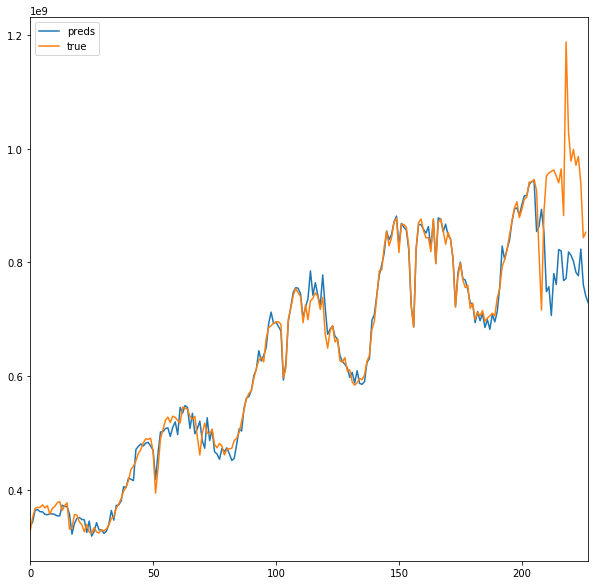

In [48]:
diffpreds.plot(figsize=(10,10))

In [80]:
x_test.iloc[-1,3] = y_test.iloc[-1]

In [113]:
dfpred = x_test.tail(1).copy()
dfpred
for i in range(1, 52):
    df_next = dfpred.tail(1).copy()
    curr_prediction = model.predict(df_next)
    df_next['day'] += 7
    df_next['month'] = (df_next['month'] + int(df_next['day']/30)) % 12
    df_year = 2019 if i < 30 else 2020
    df_next.iloc[:,4:-1] = df_next.iloc[:,3:-2].values
    df_next.iloc[:,3] = curr_prediction
    dfpred = pd.concat([dfpred, df_next],ignore_index=True)

In [114]:
dfpred

,month,year,day,count_shift1,count_shift2,count_shift3,count_shift4,count_shift5,count_shift6,count_shift7,...,count_shift42,count_shift43,count_shift44,count_shift45,count_shift46,count_shift47,count_shift48,count_shift49,count_shift50,count_shift51
0,5,2019,6,8.431754e+08,9.389841e+08,9.862300e+08,9.707602e+08,9.983522e+08,9.778192e+08,1.028534e+09,...,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,7.281859e+08,7.188549e+08,7.597770e+08,7.554838e+08,7.689702e+08,798611340.0
1,5,2019,13,7.288487e+08,8.431754e+08,9.389841e+08,9.862300e+08,9.707602e+08,9.983522e+08,9.778192e+08,...,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,7.281859e+08,7.188549e+08,7.597770e+08,7.554838e+08,798611340.0
2,5,2019,20,7.214493e+08,7.288487e+08,8.431754e+08,9.389841e+08,9.862300e+08,9.707602e+08,9.983522e+08,...,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,7.281859e+08,7.188549e+08,7.597770e+08,798611340.0
3,5,2019,27,7.054009e+08,7.214493e+08,7.288487e+08,8.431754e+08,9.389841e+08,9.862300e+08,9.707602e+08,...,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,7.281859e+08,7.188549e+08,798611340.0
4,6,2019,34,7.093520e+08,7.054009e+08,7.214493e+08,7.288487e+08,8.431754e+08,9.389841e+08,9.862300e+08,...,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,7.281859e+08,798611340.0
5,7,2019,41,6.469810e+08,7.093520e+08,7.054009e+08,7.214493e+08,7.288487e+08,8.431754e+08,9.389841e+08,...,7.058008e+08,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,6.999000e+08,798611340.0
6,8,2019,48,6.069017e+08,6.469810e+08,7.093520e+08,7.054009e+08,7.214493e+08,7.288487e+08,8.431754e+08,...,7.371461e+08,7.058008e+08,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,7.123232e+08,798611340.0
7,9,2019,55,6.370900e+08,6.069017e+08,6.469810e+08,7.093520e+08,7.054009e+08,7.214493e+08,7.288487e+08,...,7.541156e+08,7.371461e+08,7.058008e+08,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,7.058220e+08,798611340.0
8,11,2019,62,6.856334e+08,6.370900e+08,6.069017e+08,6.469810e+08,7.093520e+08,7.054009e+08,7.214493e+08,...,7.925643e+08,7.541156e+08,7.371461e+08,7.058008e+08,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,7.151029e+08,798611340.0
9,1,2019,69,6.923261e+08,6.856334e+08,6.370900e+08,6.069017e+08,6.469810e+08,7.093520e+08,7.054009e+08,...,8.044969e+08,7.925643e+08,7.541156e+08,7.371461e+08,7.058008e+08,7.104799e+08,7.054578e+08,7.020648e+08,6.964280e+08,798611340.0


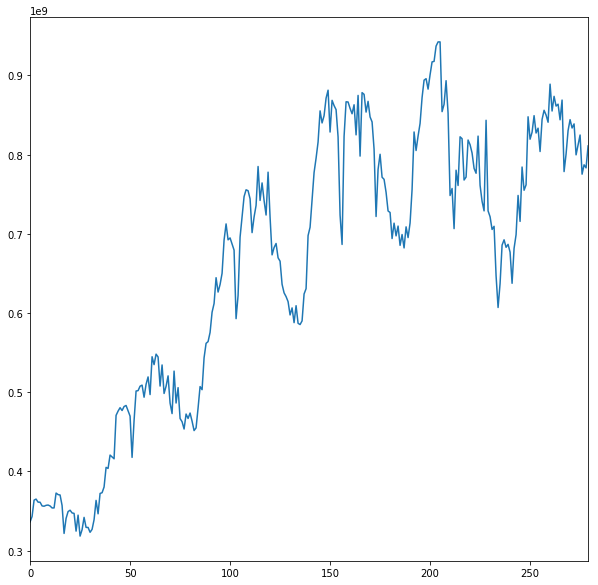

In [121]:
pd.concat([diffpreds['preds'], dfpred['count_shift1']], ignore_index=True).plot(figsize=(10,10,))